# The Code Experience with The Wekepedia Dataset

In [1]:
!pip install torch
!pip install torch_geometric

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [2]:
from torch_geometric.datasets import WikipediaNetwork
from torch_geometric.transforms import NormalizeFeatures
## determine the dataset: cora, citeseer, and pubmed
dataset = WikipediaNetwork(root='data/WikipediaNetwork', name='chameleon',transform=NormalizeFeatures())

print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.
print(data)

Processing...


Dataset: WikipediaNetwork():
Number of graphs: 1
Number of features: 2325
Number of classes: 5
Data(x=[2277, 2325], edge_index=[2, 36101], y=[2277], train_mask=[2277, 10], val_mask=[2277, 10], test_mask=[2277, 10])


Done!


In [3]:
data_dir = "./data"
dataset = WikipediaNetwork(root=data_dir, name='chameleon')
data = dataset[0]
print(f'Number of nodes: {data.num_nodes}') # Number of nodes: based on the dataset you choose
print(f'Number of edges: {data.num_edges}') # Number of edges: based on the dataset

Processing...


Number of nodes: 2277
Number of edges: 36101


Done!


In [4]:
print(f'Number of features: {data.num_node_features}') # Number of edge features: 0
print(len(data.x[0])) #display some of the features, and you can
#see that they are composed of 0s and 1s
data.x[0][:20]
print(f'Number of edge features: {data.num_edge_features}') # Number of edge features: 0
print(f'Number of classes: {dataset.num_classes}') # Number of classes: 7

Number of features: 2325
2325
Number of edge features: 0
Number of classes: 5


In [5]:
#the details for our dataset
label_dict = {
    0: "Theory",
    1: "Reinforcement_Learning",
    2: "Genetic_Algorithms",
    3: "Neural_Networks",
    4: "Probabilistic_Methods",
    5: "Case_Based",
    6: "Rule_Learning"}
data.y[:10]

tensor([0, 3, 3, 4, 2, 0, 2, 2, 0, 2])

In [6]:
from torch_geometric.nn import GCNConv
import torch
import torch.nn as nn
from torch_geometric.datasets import WebKB
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.utils import train_test_split_edges
from torch_geometric.loader import DataLoader
from sklearn.metrics import accuracy_score, roc_auc_score

# Define our own ETSA model
class ETSA(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, num_gcn_layers=1, attention_type='sigmoid', dropout_rate=0.5):
        super(ETSA, self).__init__()

        self.embedding_layer = torch.nn.Linear(num_features, hidden_dim)
        self.num_gcn_layers = num_gcn_layers
        self.gcn_layers = torch.nn.ModuleList([GCNConv(hidden_dim, hidden_dim) for _ in range(num_gcn_layers)])

        # Experiment with attention mechanisms
        if attention_type == 'sigmoid':
            self.stage_1_attention = torch.nn.Linear(hidden_dim, 1)
            self.stage_2_attention = torch.nn.Linear(hidden_dim, 1)
        elif attention_type == 'softmax':
            self.stage_1_attention = torch.nn.Linear(hidden_dim, hidden_dim)
            self.stage_2_attention = torch.nn.Linear(hidden_dim, hidden_dim)

        # Dropout for regularization
        self.dropout = torch.nn.Dropout(p=dropout_rate)

        self.final_gcn_layer = GCNConv(hidden_dim, num_classes)

    def forward(self, x, edge_index):
        # Embedding Layer
        x = self.embedding_layer(x)

        # GCN Layers with dropout
        for i in range(self.num_gcn_layers):
            x = F.relu(self.gcn_layers[i](x, edge_index))
            x = self.dropout(x)

        # Stage 1 Attention
        stage_1_attention_weights = torch.sigmoid(self.stage_1_attention(x))
        stage_1_representation = torch.sum(x * stage_1_attention_weights, dim=0)

        # Stage 2 Attention
        stage_2_attention_weights = torch.sigmoid(self.stage_2_attention(x))
        stage_2_representation = torch.sum(x * stage_2_attention_weights, dim=0)

        # Combine Stage 1 and Stage 2 Representations
        combined_representation = stage_1_representation + stage_2_representation

        # Final GCN Layer
        x = self.final_gcn_layer(x, edge_index)

        return x, combined_representation

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 1, Train Loss: 1.6235, Test Loss: 1.6247, Train Accuracy: 20.03%, Test Accuracy: 39.88%, AUC Macro: 0.7399
Epoch: 2, Train Loss: 1.6458, Test Loss: 1.8729, Train Accuracy: 34.65%, Test Accuracy: 41.06%, AUC Macro: 0.6834
Epoch: 3, Train Loss: 1.8788, Test Loss: 1.6505, Train Accuracy: 36.23%, Test Accuracy: 42.42%, AUC Macro: 0.7193
Epoch: 4, Train Loss: 1.6561, Test Loss: 1.6260, Train Accuracy: 39.92%, Test Accuracy: 40.54%, AUC Macro: 0.7144
Epoch: 5, Train Loss: 1.6570, Test Loss: 1.4597, Train Accuracy: 37.77%, Test Accuracy: 48.88%, AUC Macro: 0.7931
Epoch: 6, Train Loss: 1.4698, Test Loss: 1.4169, Train Accuracy: 45.10%, Test Accuracy: 51.30%, AUC Macro: 0.8040
Epoch: 7, Train Loss: 1.4266, Test Loss: 1.3802, Train Accuracy: 46.25%, Test Accuracy: 52.39%, AUC Macro: 0.8204
Epoch: 8, Train Loss: 1.3960, Test Loss: 1.3655, Train Accuracy: 48.70%, Test Accuracy: 53.05%, AUC Macro: 0.8155
Epoch: 9, Train Loss: 1.3910, Test Loss: 1.3172, Train Accuracy: 48.88%, Test Accuracy: 

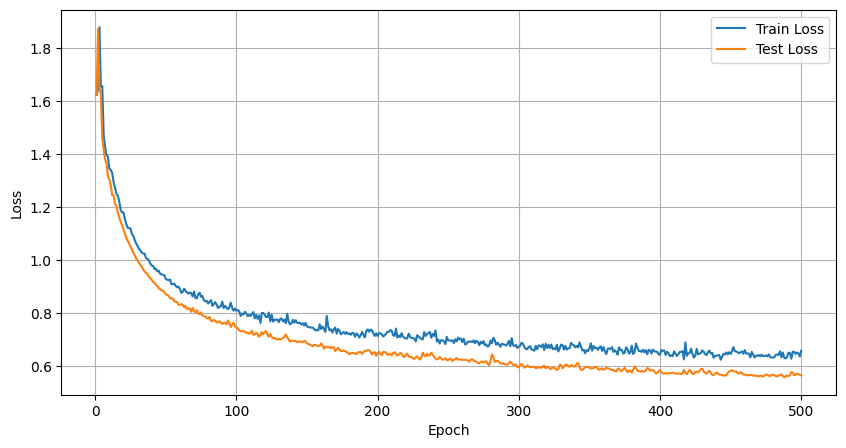

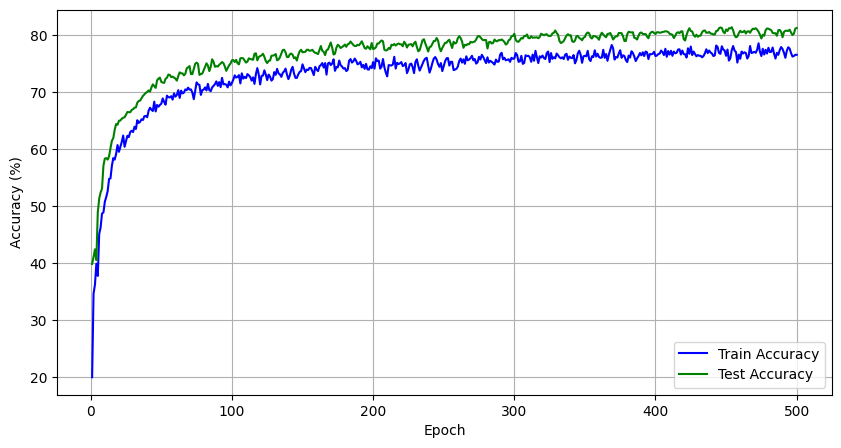

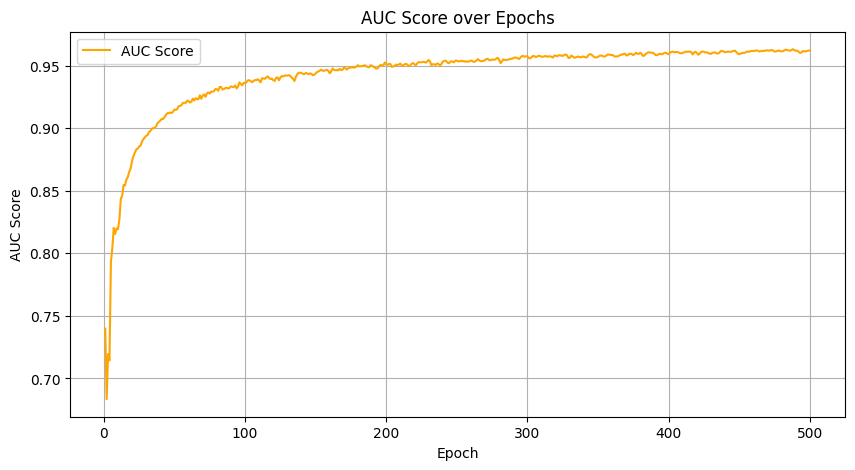

Final AUC Score: 0.9622


In [7]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import WikipediaNetwork
from torch_geometric.data import DataLoader
from torch.optim import Adam
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc
import numpy as np



# Step 1: Load the WikipediaNetwork dataset
dataset = WikipediaNetwork(root='data/WikipediaNetwork', name='chameleon')

# Step 2: Create DataLoader for the entire dataset
loader = DataLoader(dataset, batch_size=64, shuffle=True)

# Step 3: Define our ESTA model
model = ETSA(num_features=dataset.num_features, hidden_dim=64, num_classes=dataset.num_classes)

# Step 4: Define Loss Function and Optimizer
optimizer = Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

from sklearn.metrics import roc_auc_score, roc_curve, auc
import numpy as np

# Lists to store metrics for visualization
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
auc_scores = []

# Training and Evaluation loop
for epoch in range(1, 501):
    # Train the model
    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train_samples = 0
    for data in loader:
        optimizer.zero_grad()
        output, _ = model(data.x, data.edge_index)
        loss = criterion(output, data.y)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item() * data.num_graphs

        # Calculate train accuracy
        pred_train = output.argmax(dim=1)
        correct_train += pred_train.eq(data.y).sum().item()
        total_train_samples += data.y.size(0)
    train_loss = total_train_loss / len(loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train_samples * 100
    train_accuracies.append(train_accuracy)

    # Evaluate the model
    model.eval()
    total_test_loss = 0
    correct_test = 0
    total_test_samples = 0
    y_true = []
    y_score = []
    with torch.no_grad():
        for data in loader:
            output, _ = model(data.x, data.edge_index)
            total_test_loss += criterion(output, data.y).item() * data.num_graphs

            # Calculate test accuracy
            pred_test = output.argmax(dim=1)
            correct_test += pred_test.eq(data.y).sum().item()
            total_test_samples += data.y.size(0)

            # For AUC calculation
            y_true.extend(data.y.numpy())
            y_score.extend(F.softmax(output, dim=1).numpy())
    test_loss = total_test_loss / len(loader.dataset)
    test_losses.append(test_loss)
    test_accuracy = correct_test / total_test_samples * 100
    test_accuracies.append(test_accuracy)

    # Calculate AUC score
    y_true = np.array(y_true)
    y_score = np.array(y_score)
    auc_macro = roc_auc_score(y_true, y_score, multi_class='ovr')
    auc_scores.append(auc_macro)

    # Print metrics
    print(f'Epoch: {epoch}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%, AUC Macro: {auc_macro:.4f}')

# Plotting the training and testing loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, 501), train_losses, label='Train Loss')
plt.plot(range(1, 501), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('') #Training and Testing Loss
plt.legend()
plt.grid(True)
plt.show()

# Plotting the train and test accuracies
plt.figure(figsize=(10, 5))
plt.plot(range(1, 501), train_accuracies, label='Train Accuracy', color='blue')
plt.plot(range(1, 501), test_accuracies, label='Test Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('') #Train and Test Accuracies
plt.legend()
plt.grid(True)
plt.show()


# Plotting the AUC score
plt.figure(figsize=(10, 5))
plt.plot(range(1, 501), auc_scores, label='AUC Score', color='orange')
plt.xlabel('Epoch')
plt.ylabel('AUC Score')
plt.title('AUC Score over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Print final AUC score
print(f'Final AUC Score: {auc_scores[-1]:.4f}')


Epoch: 1, Train Loss: 0.6048, Test Loss: 0.5206, Train Accuracy: 78.13%, Test Accuracy: 82.04%, AUC Macro: 0.9675, Train F1 Score: 0.8196, Test F1 Score: 0.8196
Epoch: 2, Train Loss: 0.5961, Test Loss: 0.5213, Train Accuracy: 77.87%, Test Accuracy: 81.73%, AUC Macro: 0.9675, Train F1 Score: 0.8165, Test F1 Score: 0.8165
Epoch: 3, Train Loss: 0.5908, Test Loss: 0.5218, Train Accuracy: 78.52%, Test Accuracy: 81.82%, AUC Macro: 0.9674, Train F1 Score: 0.8175, Test F1 Score: 0.8175
Epoch: 4, Train Loss: 0.6022, Test Loss: 0.5190, Train Accuracy: 77.60%, Test Accuracy: 82.04%, AUC Macro: 0.9676, Train F1 Score: 0.8194, Test F1 Score: 0.8194
Epoch: 5, Train Loss: 0.5873, Test Loss: 0.5184, Train Accuracy: 77.16%, Test Accuracy: 82.35%, AUC Macro: 0.9675, Train F1 Score: 0.8225, Test F1 Score: 0.8225
Epoch: 6, Train Loss: 0.5917, Test Loss: 0.5194, Train Accuracy: 78.26%, Test Accuracy: 82.39%, AUC Macro: 0.9673, Train F1 Score: 0.8229, Test F1 Score: 0.8229
Epoch: 7, Train Loss: 0.5977, Test

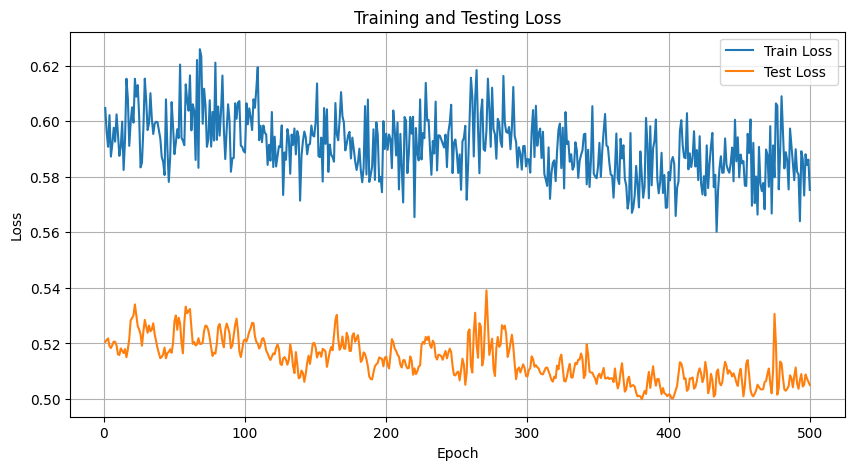

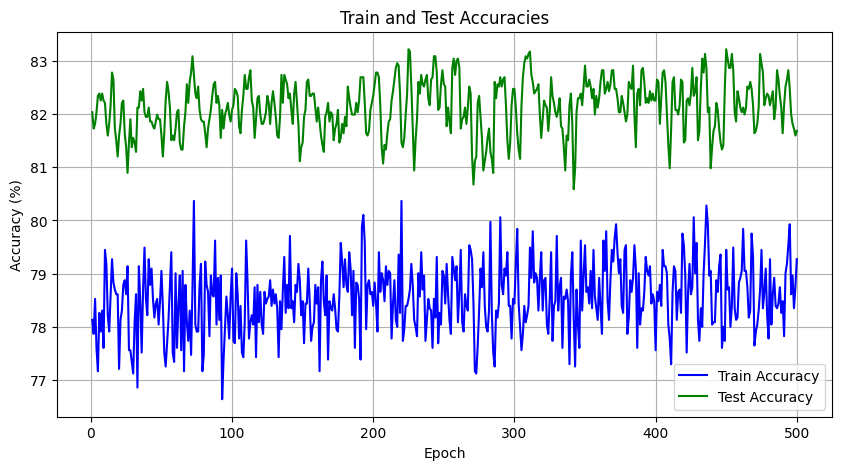

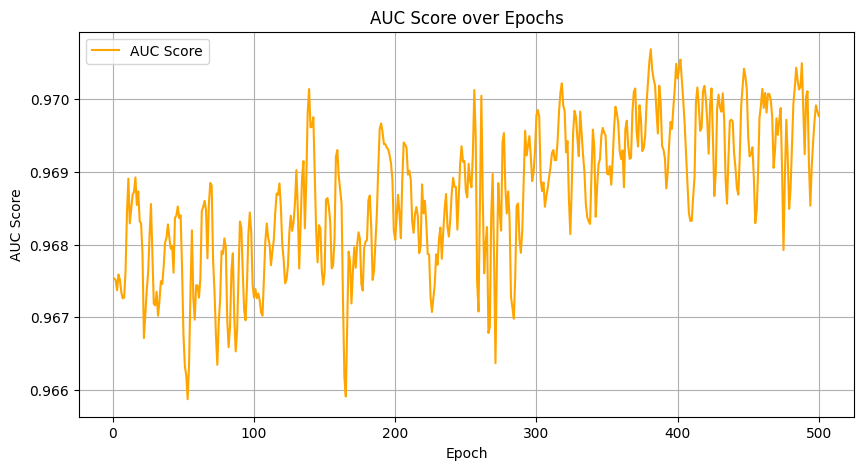

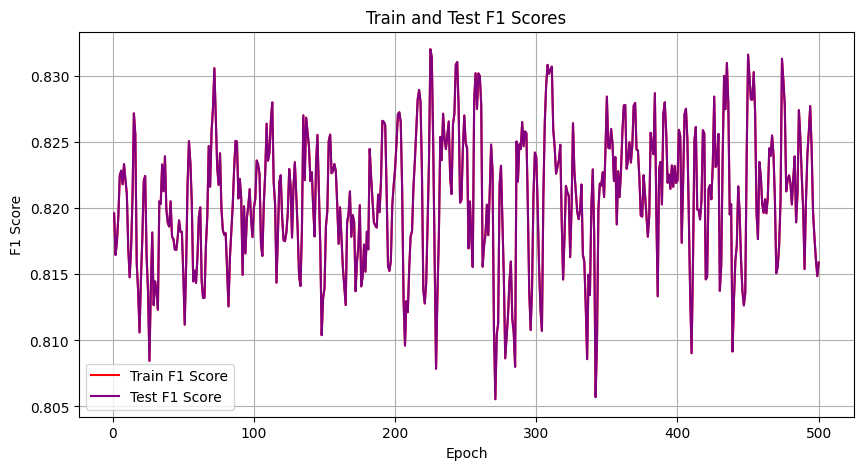

Final AUC Score: 0.9698


In [9]:
from sklearn.metrics import classification_report

# Lists to store metrics for visualization
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
auc_scores = []
train_f1_scores = []
test_f1_scores = []

# Training and Evaluation loop
for epoch in range(1, 501):
    # Train the model
    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train_samples = 0
    for data in loader:
        optimizer.zero_grad()
        output, _ = model(data.x, data.edge_index)
        loss = criterion(output, data.y)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item() * data.num_graphs

        # Calculate train accuracy
        pred_train = output.argmax(dim=1)
        correct_train += pred_train.eq(data.y).sum().item()
        total_train_samples += data.y.size(0)
    train_loss = total_train_loss / len(loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train_samples * 100
    train_accuracies.append(train_accuracy)

    # Evaluate the model
    model.eval()
    total_test_loss = 0
    correct_test = 0
    total_test_samples = 0
    y_true = []
    y_score = []
    with torch.no_grad():
        for data in loader:
            output, _ = model(data.x, data.edge_index)
            total_test_loss += criterion(output, data.y).item() * data.num_graphs

            # Calculate test accuracy
            pred_test = output.argmax(dim=1)
            correct_test += pred_test.eq(data.y).sum().item()
            total_test_samples += data.y.size(0)

            # For AUC calculation
            y_true.extend(data.y.numpy())
            y_score.extend(F.softmax(output, dim=1).numpy())
    test_loss = total_test_loss / len(loader.dataset)
    test_losses.append(test_loss)
    test_accuracy = correct_test / total_test_samples * 100
    test_accuracies.append(test_accuracy)

    # Calculate AUC score
    y_true = np.array(y_true)
    y_score = np.array(y_score)
    auc_macro = roc_auc_score(y_true, y_score, multi_class='ovr')
    auc_scores.append(auc_macro)

    # Calculate F1 score
    train_f1 = classification_report(y_true, np.argmax(y_score, axis=1), output_dict=True)['weighted avg']['f1-score']
    train_f1_scores.append(train_f1)
    test_f1 = classification_report(y_true, np.argmax(y_score, axis=1), output_dict=True)['weighted avg']['f1-score']
    test_f1_scores.append(test_f1)

    # Print metrics
    print(f'Epoch: {epoch}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%, AUC Macro: {auc_macro:.4f}, Train F1 Score: {train_f1:.4f}, Test F1 Score: {test_f1:.4f}')

# Plotting the training and testing loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, 501), train_losses, label='Train Loss')
plt.plot(range(1, 501), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the train and test accuracies
plt.figure(figsize=(10, 5))
plt.plot(range(1, 501), train_accuracies, label='Train Accuracy', color='blue')
plt.plot(range(1, 501), test_accuracies, label='Test Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train and Test Accuracies')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the AUC score
plt.figure(figsize=(10, 5))
plt.plot(range(1, 501), auc_scores, label='AUC Score', color='orange')
plt.xlabel('Epoch')
plt.ylabel('AUC Score')
plt.title('AUC Score over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the train and test F1 scores
plt.figure(figsize=(10, 5))
plt.plot(range(1, 501), train_f1_scores, label='Train F1 Score', color='red')
plt.plot(range(1, 501), test_f1_scores, label='Test F1 Score', color='purple')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Train and Test F1 Scores')
plt.legend()
plt.grid(True)
plt.show()

# Print final AUC score
print(f'Final AUC Score: {auc_scores[-1]:.4f}')
